<div style="text-align: center;">

# Accelerating Frequent Pattern Mining via Matrix Monitoring

</div>

**Notebook:** `CDM_1_Final.ipynb`  

**Project Goal:** Explore matrix sketching techniques—specifically GRP, IPCA, SpFD, and SpEmb—and assess their influence on frequent pattern mining algorithms (FP-Growth).

**Abstract:** This notebook imports the Online Retail dataset, builds a binary item–transaction matrix, and employs various matrix sketching methods to compress the transaction matrix. We then contrast the runtime, reconstruction accuracy, and pattern similarity of frequent itemset mining on the original versus the compressed matrices. Performance metrics include reconstruction error (Frobenius norm), execution time, and similarity of discovered itemsets.

## 1. Setup and Configuration
Import necessary libraries and configure the environment.

In [1]:
# ==========================================
# Essential Libraries
# ==========================================
import time                        # For measuring execution time
import copy                        # For creating deep copies of objects
import warnings                    # For handling warnings
import numpy as np                 # For numerical computations
import pandas as pd                # For dataframes and data analysis
import matplotlib.pyplot as plt    # For plotting graphs
from tqdm import tqdm              # For displaying progress bars

# ==========================================
# Linear Algebra Tools
# ==========================================
from numpy.linalg import svd, qr  # SVD and QR decomposition functions

# ==========================================
# Pattern Mining Algorithms
# ==========================================
from mlxtend.frequent_patterns import fpgrowth  # FP-Growth implementation

# ==========================================
# Incremental PCA
# ==========================================
# Using sklearn's IncrementalPCA as the sole implementation.
from sklearn.decomposition import IncrementalPCA

# ==========================================
# Configuration
# ==========================================
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

## 2. Data Loading and Preprocessing
Load the Online Retail dataset, clean the data, and construct the binary transaction matrix.

In [2]:
# ==========================================
# Dataset Loading
# ==========================================
# Load the dataset from CSV. Ensure the path is correct.

try:
    retail_data = pd.read_csv('Online Retail.csv', encoding='latin1')
except UnicodeDecodeError:
    # Fallback to utf-8 if latin1 fails
    retail_data = pd.read_csv('Online Retail.csv', encoding='utf-8', errors='ignore')

# Clean column names: remove leading/trailing whitespace
retail_data.columns = retail_data.columns.str.strip()

# Handle potential BOM or encoding artifacts in the first column name
if 'InvoiceNo' not in retail_data.columns:
    # Look for a column that contains 'InvoiceNo' (e.g., with BOM characters)
    found_col = [c for c in retail_data.columns if 'InvoiceNo' in str(c)]
    if found_col:
        print(f"Renaming column '{found_col[0]}' to 'InvoiceNo'")
        retail_data.rename(columns={found_col[0]: 'InvoiceNo'}, inplace=True)

# Display initial dataset dimensions and columns to verify loading
print("Raw data shape:", retail_data.shape)
print("Columns:", retail_data.columns.tolist())

Renaming column 'ï»¿InvoiceNo' to 'InvoiceNo'
Raw data shape: (541909, 8)
Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


In [3]:
# ==========================================
# Data Inspection
# ==========================================

# View the first few records
display(retail_data.head())

# Get a summary of the dataframe (columns, types, memory)
retail_data.info()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
# ==========================================
# Preprocessing & Cleaning
# ==========================================

# Parse dates
retail_data['InvoiceDate'] = pd.to_datetime(retail_data['InvoiceDate'], errors='coerce')

# Remove missing values and duplicates
cleaned_data = retail_data.dropna().drop_duplicates().copy()

# Filter out negative quantities/prices (returns)
cleaned_data = cleaned_data[(cleaned_data['Quantity'] > 0) | (cleaned_data['UnitPrice'] > 0)]

# Exclude cancelled invoices (starting with 'C')
cleaned_data = cleaned_data[~cleaned_data['InvoiceNo'].astype(str).str.startswith('C')]

# Filter StockCodes (standard format: digits + optional letter)
cleaned_data = cleaned_data[cleaned_data['StockCode'].astype(str).str.match(r'^\d{1,5}[A-Z]?$')]

# Output cleaned data dimensions
print("Cleaned data shape:", cleaned_data.shape)

# Preview cleaned data
display(cleaned_data.head())

Cleaned data shape: (390892, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# ==========================================
# Construct Binary Matrix
# ==========================================
# Create a matrix where rows are invoices and columns are items.

# Group by Invoice and StockCode
transaction_matrix = cleaned_data.groupby(['InvoiceNo', 'StockCode']).size().unstack(fill_value=0)

# Binarize the matrix (1 if item exists in invoice, else 0)
transaction_matrix = (transaction_matrix > 0).astype(float)

# Display matrix info
print("Item-transaction matrix shape:", transaction_matrix.shape)
display(transaction_matrix.head())

Item-transaction matrix shape: (18404, 3658)


StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# ==========================================
# Date Range Analysis
# ==========================================

# Extract unique invoice dates
unique_invoice_dates = cleaned_data[['InvoiceNo', 'InvoiceDate']].drop_duplicates().set_index('InvoiceNo')

# Print the time span
print(
    "Transaction date range:",
    unique_invoice_dates['InvoiceDate'].min(),
    "to",
    unique_invoice_dates['InvoiceDate'].max()
)

Transaction date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [7]:
# ==========================================
# Batch Creation
# ==========================================

# Sort invoices by date
sorted_invoices = (
    cleaned_data[['InvoiceNo', 'InvoiceDate']]
    .drop_duplicates()
    .sort_values('InvoiceDate')
)

# Align matrix rows with sorted invoices
transaction_matrix = transaction_matrix.loc[sorted_invoices['InvoiceNo']]

# ==========================================
# Partitioning
# ==========================================
num_chunks = 10
chunk_size = len(transaction_matrix) // num_chunks

data_chunks = []

for idx in range(num_chunks):
    # Determine indices
    idx_start = idx * chunk_size
    idx_end = (idx + 1) * chunk_size if idx < num_chunks - 1 else len(transaction_matrix)
    
    # Slice the matrix
    chunk_df = transaction_matrix.iloc[idx_start:idx_end]
    data_chunks.append(chunk_df)
    
    # Get date range for the chunk
    chunk_invoices = sorted_invoices.iloc[idx_start:idx_end]
    d_start = chunk_invoices['InvoiceDate'].min()
    d_end = chunk_invoices['InvoiceDate'].max()
    
    # Output chunk info
    print(f"Batch {idx+1}: shape={chunk_df.shape}, from {d_start} to {d_end}")

Batch 1: shape=(1843, 3658), from 2010-12-01 08:26:00 to 2011-01-16 13:54:00
Batch 2: shape=(1843, 3658), from 2011-01-16 14:36:00 to 2011-03-08 14:47:00
Batch 3: shape=(1843, 3658), from 2011-03-08 15:03:00 to 2011-04-19 16:31:00
Batch 4: shape=(1843, 3658), from 2011-04-19 16:37:00 to 2011-05-31 14:14:00
Batch 5: shape=(1843, 3658), from 2011-05-31 14:14:00 to 2011-07-12 11:15:00
Batch 6: shape=(1843, 3658), from 2011-07-12 11:16:00 to 2011-08-23 13:30:00
Batch 7: shape=(1843, 3658), from 2011-08-23 13:35:00 to 2011-09-28 13:23:00
Batch 8: shape=(1843, 3658), from 2011-09-28 13:30:00 to 2011-10-27 14:27:00
Batch 9: shape=(1843, 3658), from 2011-10-27 14:38:00 to 2011-11-18 13:02:00
Batch 10: shape=(1847, 3658), from 2011-11-18 13:14:00 to 2011-12-09 12:50:00


## 3. Matrix Sketching Techniques
We apply three different matrix sketching techniques to compress the transaction matrix.

### 3.1 Gaussian Random Projection (GRP)

100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


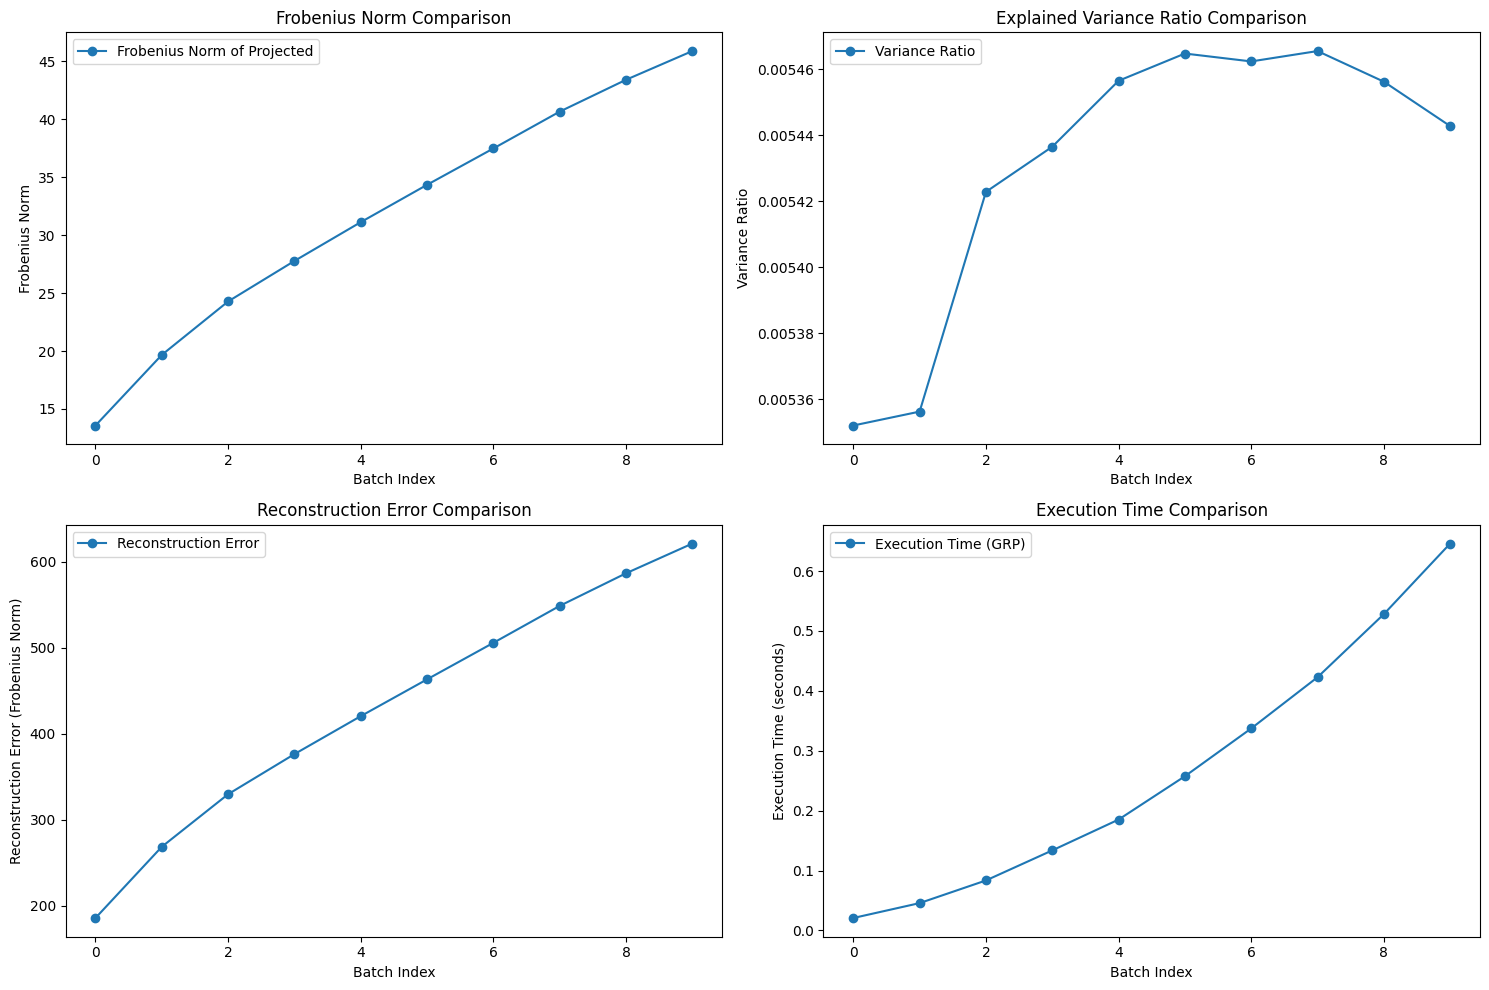

In [8]:
# ==========================================
# Gaussian Random Projection (GRP)
# ==========================================

num_features = data_chunks[0].shape[1]
TARGET_DIM = 20

def apply_grp(matrix, k=TARGET_DIM):
    """
    Perform Gaussian Random Projection.
    """
    np.random.seed(2020)
    
    rows, cols = matrix.shape
    # Generate random Gaussian matrix
    rand_mat = np.random.normal(0, 1/np.sqrt(k), (cols, k))
    
    # Orthogonalize
    Q_mat = np.linalg.qr(rand_mat)[0]
    
    # Project
    sketched = matrix @ Q_mat
    
    # Reconstruct
    approx = sketched @ Q_mat.T
    
    return sketched, approx


# ==========================================
# Results Storage
# ==========================================
grp_projections = []
grp_reconstructions = []
grp_fro_norms = []
grp_var_ratios = []
grp_rec_errors = []
grp_exec_times = []

accumulated_data = None
counter = 0

# ==========================================
# Batch Processing
# ==========================================
for idx, chunk_data in enumerate(tqdm(data_chunks)):
    # Accumulate data
    if accumulated_data is None:
        accumulated_data = chunk_data
    else:
        accumulated_data = np.vstack((accumulated_data, chunk_data))
    
    # Timing start
    t_start = time.time()
    
    # Run GRP
    proj_mat, rec_mat = apply_grp(accumulated_data, k=TARGET_DIM)
    
    # Save outputs
    grp_projections.append(proj_mat)
    grp_reconstructions.append(rec_mat)
    
    # Timing end
    t_end = time.time()
    elapsed = t_end - t_start
    if grp_exec_times:
        grp_exec_times.append(elapsed + grp_exec_times[-1])
    else:
        grp_exec_times.append(elapsed)
    
    # Calculate Error
    if counter == 0:
        # Handle potential dataframe vs numpy array difference
        err_val = np.linalg.norm(accumulated_data.values - rec_mat.values, 'fro') 
    else:
        err_val = np.linalg.norm(accumulated_data - rec_mat, 'fro') 
    
    counter += 1
    
    # Variance Ratio
    var_total = np.sum(np.var(accumulated_data, axis=0))
    var_proj = np.sum(np.var(proj_mat, axis=0))
    ratio = var_proj / var_total
    
    # Frobenius Norms
    norm_proj = np.linalg.norm(proj_mat, 'fro')
    
    # Append stats
    grp_fro_norms.append(norm_proj)
    grp_var_ratios.append(ratio)
    grp_rec_errors.append(err_val)

# ==========================================
# Visualization
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Frobenius Norm
axes[0][0].plot(range(len(data_chunks)), grp_fro_norms, 'o-', label='Frobenius Norm of Projected')
axes[0][0].set_title('Frobenius Norm Comparison')
axes[0][0].set_xlabel('Batch Index')
axes[0][0].set_ylabel('Frobenius Norm')
axes[0][0].legend()

# Variance Ratio
axes[0][1].plot(range(len(data_chunks)), grp_var_ratios, 'o-', label='Variance Ratio')
axes[0][1].set_title('Explained Variance Ratio Comparison')
axes[0][1].set_xlabel('Batch Index')
axes[0][1].set_ylabel('Variance Ratio')
axes[0][1].legend()

# Reconstruction Error
axes[1][0].plot(range(len(data_chunks)), grp_rec_errors, 'o-', label='Reconstruction Error')
axes[1][0].set_title('Reconstruction Error Comparison')
axes[1][0].set_xlabel('Batch Index')
axes[1][0].set_ylabel('Reconstruction Error (Frobenius Norm)')
axes[1][0].legend()

# Execution Time
axes[1][1].plot(range(len(data_chunks)), grp_exec_times, 'o-', label='Execution Time (GRP)')
axes[1][1].set_title('Execution Time Comparison')
axes[1][1].set_xlabel('Batch Index')
axes[1][1].set_ylabel('Execution Time (seconds)')
axes[1][1].legend()

plt.tight_layout()
plt.show()

### 3.2 Incremental PCA (IPCA)

100%|██████████| 10/10 [00:59<00:00,  5.97s/it]


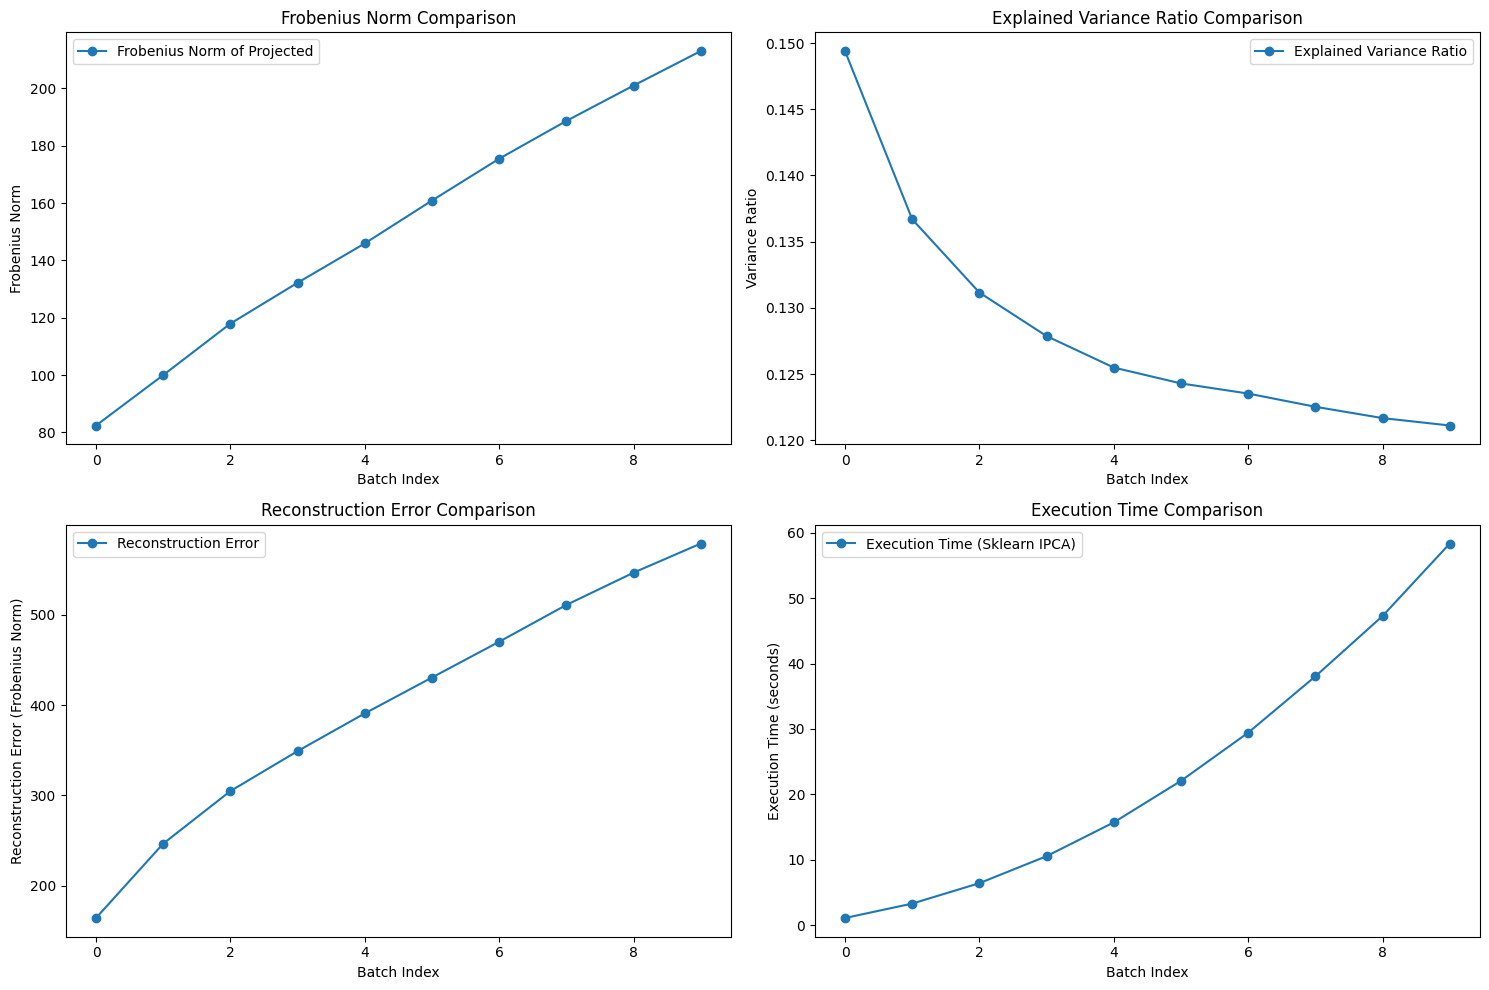

In [9]:
# ==========================================
# Incremental PCA (IPCA) with Sklearn
# ==========================================

# Use the data chunks directly (they are already DataFrames/NumPy arrays)
# No need to convert to TensorFlow constants.

# Configuration
num_features = data_chunks[0].shape[1]
NUM_COMPONENTS = 20
MINI_BATCH_SIZE = 200

# Initialize IPCA
inc_pca = IncrementalPCA(n_components=NUM_COMPONENTS)

# ==========================================
# Results Storage
# ==========================================
ipca_projections = []
ipca_reconstructions = []
ipca_fro_norms = []
ipca_var_ratios = []
ipca_rec_errors = []
ipca_exec_times = []

accumulated_data = None

# ==========================================
# Batch Processing
# ==========================================
for idx, chunk_data in enumerate(tqdm(data_chunks)):
    # Accumulate
    # Ensure we are working with numpy arrays
    current_chunk_np = chunk_data.values if hasattr(chunk_data, 'values') else chunk_data
    
    if accumulated_data is None:
        accumulated_data = current_chunk_np
    else:
        accumulated_data = np.vstack((accumulated_data, current_chunk_np))
    
    # Create mini-batches manually for IncrementalPCA
    n_samples = accumulated_data.shape[0]
    
    temp_proj = []
    temp_rec = []
    
    # Timing start
    t_start = time.time()
    
    # Fit and transform in mini-batches
    for start_idx in range(0, n_samples, MINI_BATCH_SIZE):
        end_idx = min(start_idx + MINI_BATCH_SIZE, n_samples)
        mini_batch = accumulated_data[start_idx:end_idx]
        
        # Partial fit
        inc_pca.partial_fit(mini_batch)
        
        # Transform
        proj = inc_pca.transform(mini_batch)
        temp_proj.append(proj)
        
        # Inverse Transform (Reconstruct)
        rec = inc_pca.inverse_transform(proj)
        temp_rec.append(rec)
    
    # Merge results
    final_proj = np.vstack(temp_proj)
    final_rec = np.vstack(temp_rec)
    
    # Timing end
    t_end = time.time()
    elapsed = t_end - t_start
    
    if ipca_exec_times:
        ipca_exec_times.append(elapsed + ipca_exec_times[-1])
    else:
        ipca_exec_times.append(elapsed)
    
    # Store results
    ipca_projections.append(final_proj)
    ipca_reconstructions.append(final_rec)

    # Metrics
    err_val = np.linalg.norm(accumulated_data - final_rec, 'fro')
    ratio = np.sum(inc_pca.explained_variance_ratio_)
    norm_proj = np.linalg.norm(final_proj, 'fro')
    
    ipca_fro_norms.append(norm_proj)
    ipca_var_ratios.append(ratio)
    ipca_rec_errors.append(err_val)

# ==========================================
# Visualization
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Frobenius Norm
axes[0][0].plot(range(len(data_chunks)), ipca_fro_norms, 'o-', label='Frobenius Norm of Projected')
axes[0][0].set_title('Frobenius Norm Comparison')
axes[0][0].set_xlabel('Batch Index')
axes[0][0].set_ylabel('Frobenius Norm')
axes[0][0].legend()

# Variance Ratio
axes[0][1].plot(range(len(data_chunks)), ipca_var_ratios, 'o-', label='Explained Variance Ratio')
axes[0][1].set_title('Explained Variance Ratio Comparison')
axes[0][1].set_xlabel('Batch Index')
axes[0][1].set_ylabel('Variance Ratio')
axes[0][1].legend()

# Reconstruction Error
axes[1][0].plot(range(len(data_chunks)), ipca_rec_errors, 'o-', label='Reconstruction Error')
axes[1][0].set_title('Reconstruction Error Comparison')
axes[1][0].set_xlabel('Batch Index')
axes[1][0].set_ylabel('Reconstruction Error (Frobenius Norm)')
axes[1][0].legend()

# Execution Time
axes[1][1].plot(range(len(data_chunks)), ipca_exec_times, 'o-', label='Execution Time (Sklearn IPCA)')
axes[1][1].set_title('Execution Time Comparison')
axes[1][1].set_xlabel('Batch Index')
axes[1][1].set_ylabel('Execution Time (seconds)')
axes[1][1].legend()

plt.tight_layout()
plt.show()

### 3.3 Sparse Frequent Directions (SpFD)

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


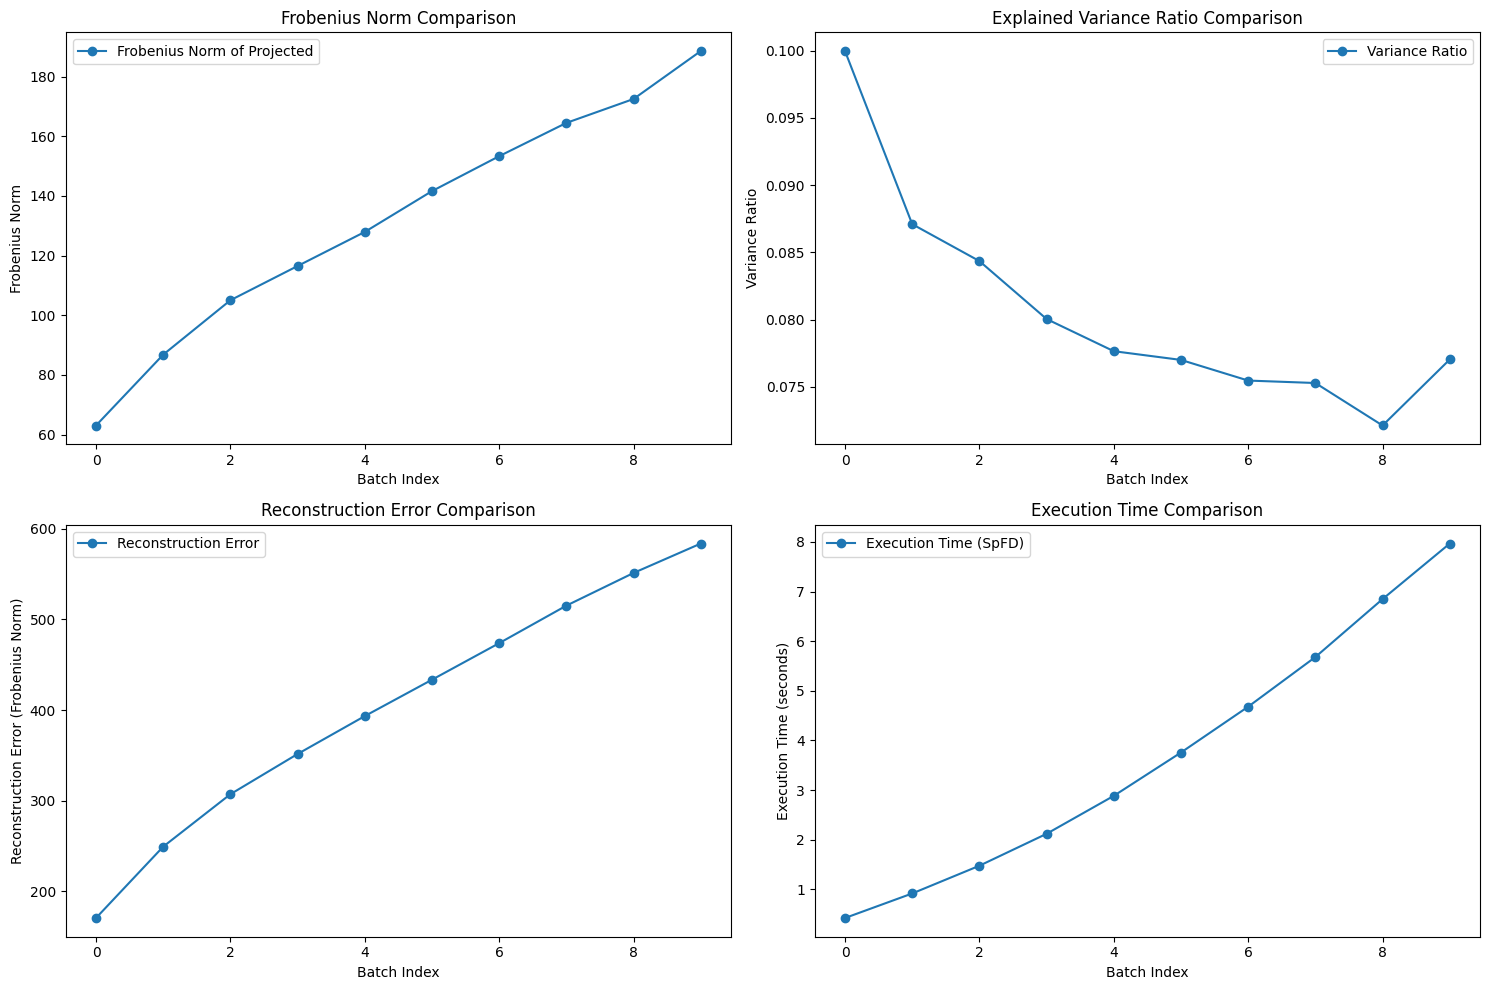

In [10]:
# ==========================================
# Sparse Embedding & Frequent Directions
# ==========================================
# Based on: Teng & Chu, "A Fast Frequent Directions Algorithm..."

class SparseEmbedding:
    """
    Implements Sparse Embedding (SpEmb).
    """
    def __init__(self, sketch_dim, rank, seed=2020):
        self.l_dim = sketch_dim
        self.k_rank = rank
        self.random_gen = np.random.default_rng(seed)

    def _generate_sparse_matrix(self, n_cols):
        """
        Generates the sparse embedding matrix S.
        """
        row_indices = self.random_gen.integers(low=0, high=self.l_dim, size=n_cols)
        sign_vals = self.random_gen.choice([-1, 1], size=n_cols)
        S_mat = np.zeros((self.l_dim, n_cols))
        S_mat[row_indices, np.arange(n_cols)] = sign_vals
        return S_mat

    def fit_transform(self, input_matrix):
        """
        Projects and reconstructs the input matrix.
        """
        n_rows, _ = input_matrix.shape
        S_mat = self._generate_sparse_matrix(n_rows)
        B_mat = S_mat @ input_matrix

        # Orthonormal basis
        Q_mat, _ = qr(B_mat.T, mode='reduced')
        V_mat = Q_mat
        AV_mat = input_matrix @ V_mat

        # Truncated SVD
        U_trunc, s_trunc, Vt_trunc = svd(AV_mat, full_matrices=False)
        
        # Reconstruction
        approx_matrix = (U_trunc[:, :self.k_rank] @ np.diag(s_trunc[:self.k_rank])) @ (Vt_trunc[:self.k_rank, :] @ V_mat.T)
        return AV_mat[:, :self.k_rank], approx_matrix


class SparseFrequentDirections:
    """
    Implements Sparse Frequent Directions (SpFD).
    """
    def __init__(self, sketch_dim, rank, blocks=5, seed=2020):
        self.l_dim = sketch_dim
        self.k_rank = rank
        self.num_blocks = blocks
        self.random_gen = np.random.default_rng(seed)

    def _generate_sparse_matrix(self, n_cols):
        """
        Generates sparse embedding matrix.
        """
        row_indices = self.random_gen.integers(low=0, high=self.l_dim, size=n_cols)
        sign_vals = self.random_gen.choice([-1, 1], size=n_cols)
        S_mat = np.zeros((self.l_dim, n_cols))
        S_mat[row_indices, np.arange(n_cols)] = sign_vals
        return S_mat

    def _process_block(self, block_matrix):
        """
        Applies SpEmb to a block.
        """
        n_rows = block_matrix.shape[0]
        S_mat = self._generate_sparse_matrix(n_rows)
        return S_mat @ block_matrix

    def fit_transform(self, input_matrix):
        """
        Projects and reconstructs using SpFD.
        """
        n_rows, _ = input_matrix.shape
        perm_indices = self.random_gen.permutation(n_rows)
        permuted_matrix = input_matrix[perm_indices]

        # First block
        block_size = n_rows // self.num_blocks
        B_mat = self._process_block(permuted_matrix[:block_size, :])

        # Subsequent blocks
        for i in range(1, self.num_blocks):
            current_block = permuted_matrix[i*block_size:(i+1)*block_size, :]
            new_B = self._process_block(current_block)
            B_mat = np.vstack((B_mat, new_B))

            # SVD Shrinkage
            U, s, Vt = svd(B_mat, full_matrices=False)
            s_shrunk = np.sqrt(np.maximum(s**2 - s[self.l_dim]**2, 0))
            B_mat = (U[:, :self.l_dim] * s_shrunk[:self.l_dim]) @ Vt[:self.l_dim, :]

        # Orthonormal basis
        Q_mat, _ = qr(B_mat.T, mode='reduced')
        V_mat = Q_mat
        AV_mat = input_matrix @ V_mat

        # Final Reconstruction
        U_trunc, s_trunc, Vt_trunc = svd(AV_mat, full_matrices=False)
        approx_matrix = (U_trunc[:, :self.k_rank] @ np.diag(s_trunc[:self.k_rank])) @ (Vt_trunc[:self.k_rank, :] @ V_mat.T)
        return AV_mat[:, :self.k_rank], approx_matrix


# ==========================================
# Setup
# ==========================================
TARGET_DIM = 20
SKETCH_DIM = 100
BLOCK_COUNT = 3
algo_choice = "SpFD"

# Instantiate
if algo_choice == "SpEmb":
    sketching_model = SparseEmbedding(sketch_dim=SKETCH_DIM, rank=TARGET_DIM)
else:
    sketching_model = SparseFrequentDirections(sketch_dim=SKETCH_DIM, rank=TARGET_DIM, blocks=BLOCK_COUNT)

# ==========================================
# Results Storage
# ==========================================
spfd_projections = []
spfd_reconstructions = []
spfd_fro_norms = []
spfd_var_ratios = []
spfd_rec_errors = []
spfd_exec_times = []

accumulated_data = None

# ==========================================
# Batch Processing
# ==========================================
for idx, chunk_data in enumerate(tqdm(data_chunks)):
    # Accumulate
    if accumulated_data is None:
        accumulated_data = chunk_data.values
    else:
        accumulated_data = np.vstack((accumulated_data, chunk_data.values))

    # Timing start
    t_start = time.time()
    proj_mat, rec_mat = sketching_model.fit_transform(accumulated_data)
    t_end = time.time()

    # Store
    spfd_projections.append(proj_mat)
    spfd_reconstructions.append(rec_mat)

    # Timing accumulation
    elapsed = t_end - t_start
    if spfd_exec_times:
        spfd_exec_times.append(elapsed + spfd_exec_times[-1])
    else:
        spfd_exec_times.append(elapsed)

    # Metrics
    err_val = np.linalg.norm(accumulated_data - rec_mat, 'fro')
    var_total = np.sum(np.var(accumulated_data, axis=0))
    var_proj = np.sum(np.var(proj_mat, axis=0))
    ratio = var_proj / var_total

    spfd_fro_norms.append(np.linalg.norm(proj_mat, 'fro'))
    spfd_var_ratios.append(ratio)
    spfd_rec_errors.append(err_val)

# ==========================================
# Visualization
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Frobenius Norm
axes[0][0].plot(range(len(data_chunks)), spfd_fro_norms, 'o-', label='Frobenius Norm of Projected')
axes[0][0].set_title('Frobenius Norm Comparison')
axes[0][0].set_xlabel('Batch Index')
axes[0][0].set_ylabel('Frobenius Norm')
axes[0][0].legend()

# Variance Ratio
axes[0][1].plot(range(len(data_chunks)), spfd_var_ratios, 'o-', label='Variance Ratio')
axes[0][1].set_title('Explained Variance Ratio Comparison')
axes[0][1].set_xlabel('Batch Index')
axes[0][1].set_ylabel('Variance Ratio')
axes[0][1].legend()

# Reconstruction Error
axes[1][0].plot(range(len(data_chunks)), spfd_rec_errors, 'o-', label='Reconstruction Error')
axes[1][0].set_title('Reconstruction Error Comparison')
axes[1][0].set_xlabel('Batch Index')
axes[1][0].set_ylabel('Reconstruction Error (Frobenius Norm)')
axes[1][0].legend()

# Execution Time
axes[1][1].plot(range(len(data_chunks)), spfd_exec_times, 'o-', label=f'Execution Time ({algo_choice})')
axes[1][1].set_title('Execution Time Comparison')
axes[1][1].set_xlabel('Batch Index')
axes[1][1].set_ylabel('Execution Time (seconds)')
axes[1][1].legend()

plt.tight_layout()
plt.show()

## 4. Comparative Analysis
Compare the reconstruction error, explained variance, and execution time of the three methods.

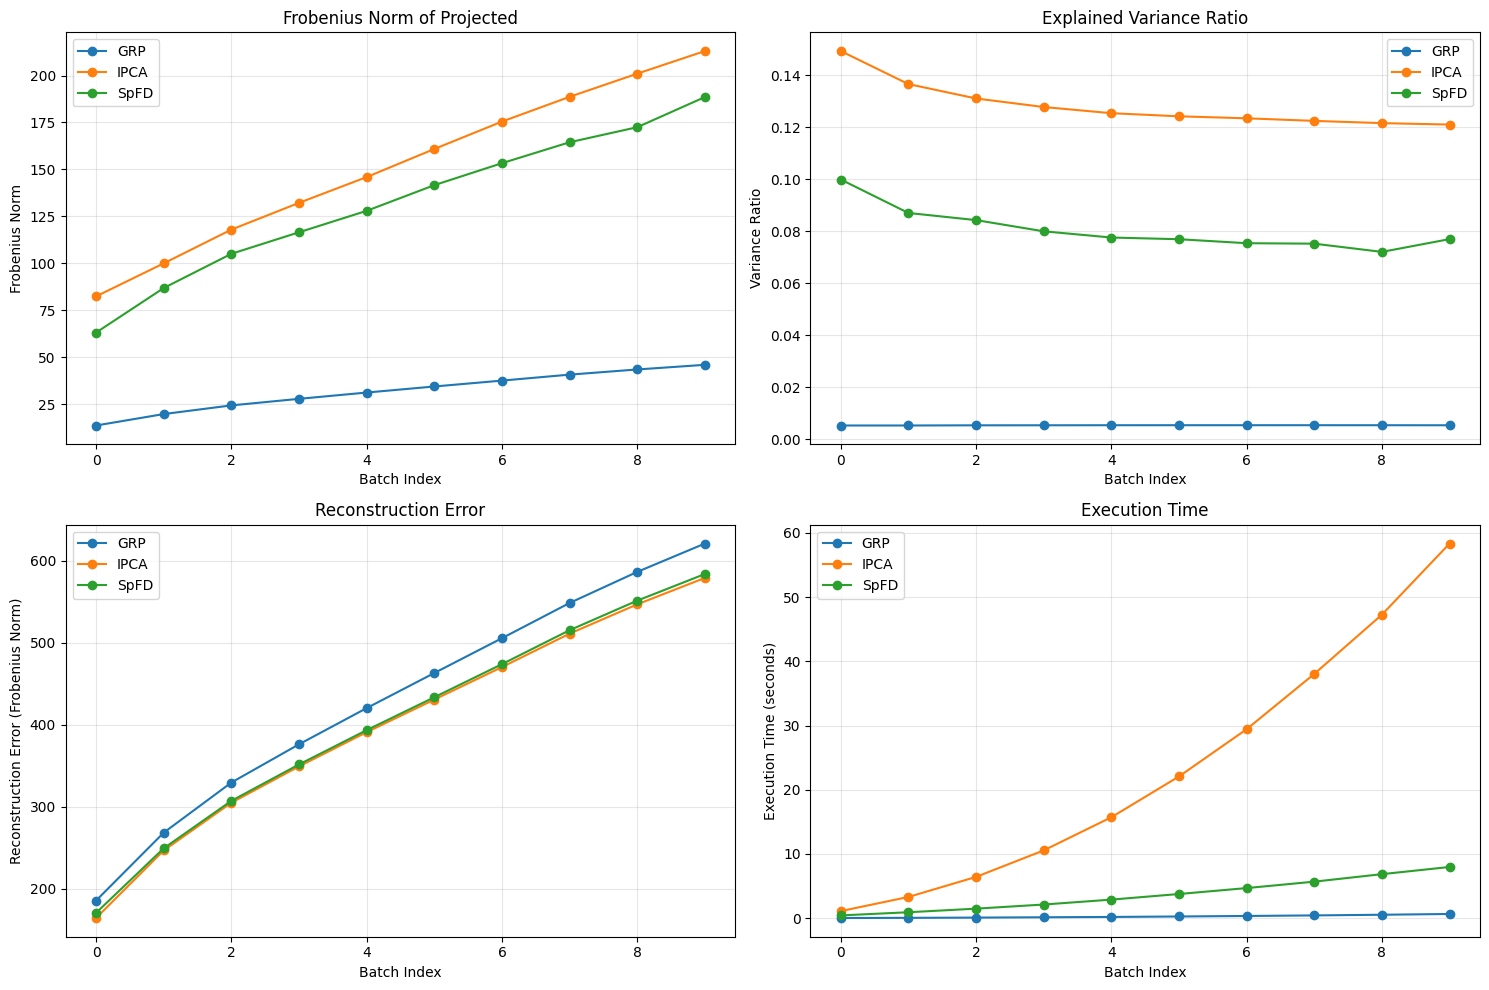

In [11]:
# ==========================================
# Comparative Analysis
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Frobenius Norm
axes[0, 0].plot(range(len(data_chunks)), grp_fro_norms, 'o-', label='GRP')
axes[0, 0].plot(range(len(data_chunks)), ipca_fro_norms, 'o-', label='IPCA')
axes[0, 0].plot(range(len(data_chunks)), spfd_fro_norms, 'o-', label='SpFD')
axes[0, 0].set_title('Frobenius Norm of Projected')
axes[0, 0].set_xlabel('Batch Index')
axes[0, 0].set_ylabel('Frobenius Norm')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Variance Ratio
axes[0, 1].plot(range(len(data_chunks)), grp_var_ratios, 'o-', label='GRP')
axes[0, 1].plot(range(len(data_chunks)), ipca_var_ratios, 'o-', label='IPCA')
axes[0, 1].plot(range(len(data_chunks)), spfd_var_ratios, 'o-', label='SpFD')
axes[0, 1].set_title('Explained Variance Ratio')
axes[0, 1].set_xlabel('Batch Index')
axes[0, 1].set_ylabel('Variance Ratio')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Reconstruction Error
axes[1, 0].plot(range(len(data_chunks)), grp_rec_errors, 'o-', label='GRP')
axes[1, 0].plot(range(len(data_chunks)), ipca_rec_errors, 'o-', label='IPCA')
axes[1, 0].plot(range(len(data_chunks)), spfd_rec_errors, 'o-', label='SpFD')
axes[1, 0].set_title('Reconstruction Error')
axes[1, 0].set_xlabel('Batch Index')
axes[1, 0].set_ylabel('Reconstruction Error (Frobenius Norm)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Execution Time
axes[1, 1].plot(range(len(data_chunks)), grp_exec_times, 'o-', label='GRP')
axes[1, 1].plot(range(len(data_chunks)), ipca_exec_times, 'o-', label='IPCA')
axes[1, 1].plot(range(len(data_chunks)), spfd_exec_times, 'o-', label='SpFD')
axes[1, 1].set_title('Execution Time')
axes[1, 1].set_xlabel('Batch Index')
axes[1, 1].set_ylabel('Execution Time (seconds)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Frequent Pattern Mining
Binarize the projected matrices and run FP-Growth to compare the discovered patterns with those from the original data.

In [12]:
# ==========================================
# DataFrame Conversion
# ==========================================

# GRP
grp_df = pd.DataFrame(
    grp_projections[-1],
    index=transaction_matrix.index
)

# IPCA
ipca_df = pd.DataFrame(
    ipca_projections[-1],
    index=transaction_matrix.index
)

# SpFD
spfd_df = pd.DataFrame(
    spfd_projections[-1],
    index=transaction_matrix.index
)

# Verify dimensions
print("GRP projected shape:", grp_df.shape)
print("IPCA projected shape:", ipca_df.shape)
print("SpFD projected shape:", spfd_df.shape)

GRP projected shape: (18434, 20)
IPCA projected shape: (18434, 20)
SpFD projected shape: (18434, 20)


In [13]:
# ==========================================
# Binarization Logic
# ==========================================
def make_binary(dataframe, quantile_val=0.90):
    """
    Transforms continuous matrix to binary based on statistical thresholds.
    """
    thresh_dict = {}
    binary_result = pd.DataFrame(index=dataframe.index)

    for column_name in dataframe.columns:
        values = dataframe[column_name].to_numpy()
        magnitudes = np.abs(values)

        if np.all(magnitudes == 0):
            bool_mask = np.zeros_like(magnitudes, dtype=bool)
            threshold = np.nan
        else:
            # IQR and Quantile logic
            quartile1, quartile3 = np.quantile(magnitudes, [0.25, 0.75])
            inter_quartile = quartile3 - quartile1
            thresh_iqr = quartile3 + 1.5 * inter_quartile
            thresh_quant = np.quantile(magnitudes, quantile_val)
            threshold = max(thresh_iqr, thresh_quant)

            if threshold <= 0:
                threshold = np.quantile(magnitudes, 0.999)

            bool_mask = magnitudes >= threshold

        binary_result[column_name] = bool_mask
        thresh_dict[column_name] = threshold
        
    return binary_result.astype(bool), pd.Series(thresh_dict)


# ==========================================
# Apply Binarization
# ==========================================
ipca_bin, ipca_thresh = make_binary(ipca_df, quantile_val=0.90)
grp_bin, grp_thresh = make_binary(grp_df, quantile_val=0.90)
spfd_bin, spfd_thresh = make_binary(spfd_df, quantile_val=0.90)


# ==========================================
# Sparsity Analysis
# ==========================================
def print_sparsity_stats(label, binary_df):
    """
    Outputs sparsity metrics.
    """
    rates = binary_df.mean(axis=0)
    print(f"{label}: mean ones rate={rates.mean():.3f}, "
          f"median={rates.median():.3f}, "
          f"max={rates.max():.3f}, min={rates.min():.3f}")


# Show stats
print_sparsity_stats("IPCA-bin", ipca_bin)
print_sparsity_stats("GRP-bin", grp_bin)
print_sparsity_stats("SpFD-bin", spfd_bin)

IPCA-bin: mean ones rate=0.061, median=0.059, max=0.085, min=0.050
GRP-bin: mean ones rate=0.047, median=0.047, max=0.052, min=0.043
SpFD-bin: mean ones rate=0.058, median=0.056, max=0.100, min=0.045


Running FP-Growth on Original...
  Time: 0.50s, Patterns: 20
Running FP-Growth on GRP...
  Time: 0.02s, Patterns: 1
Running FP-Growth on IPCA...
  Time: 0.04s, Patterns: 19
Running FP-Growth on SpFD...
  Time: 0.03s, Patterns: 18


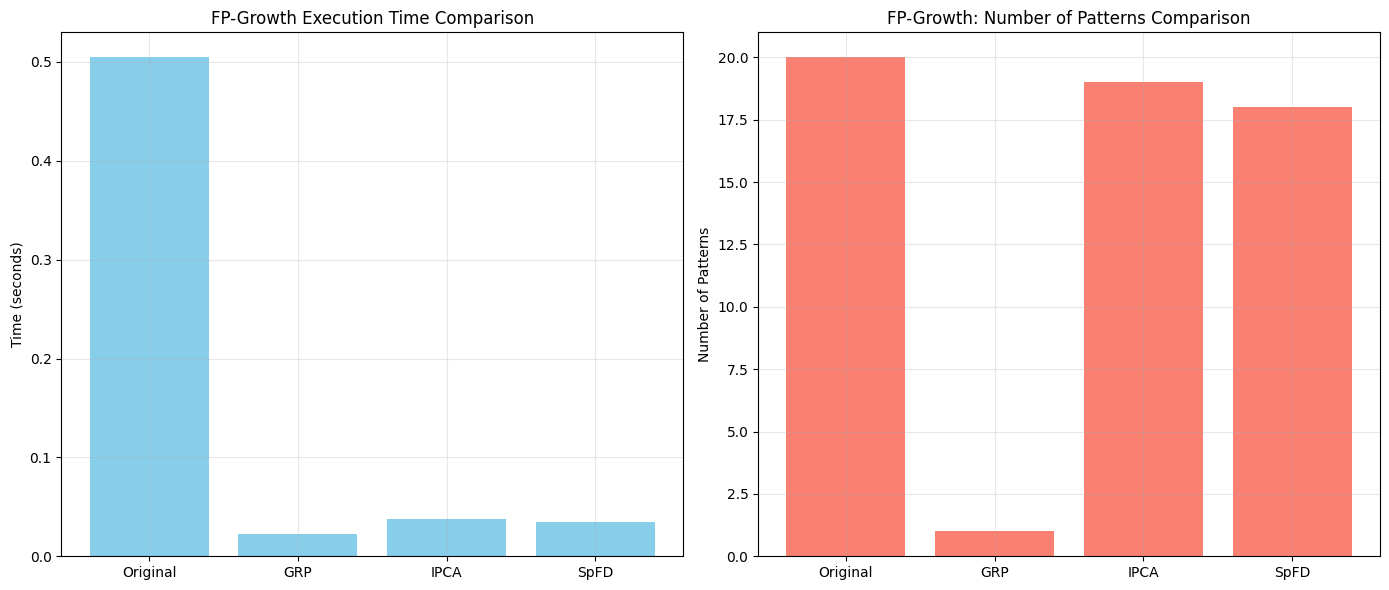

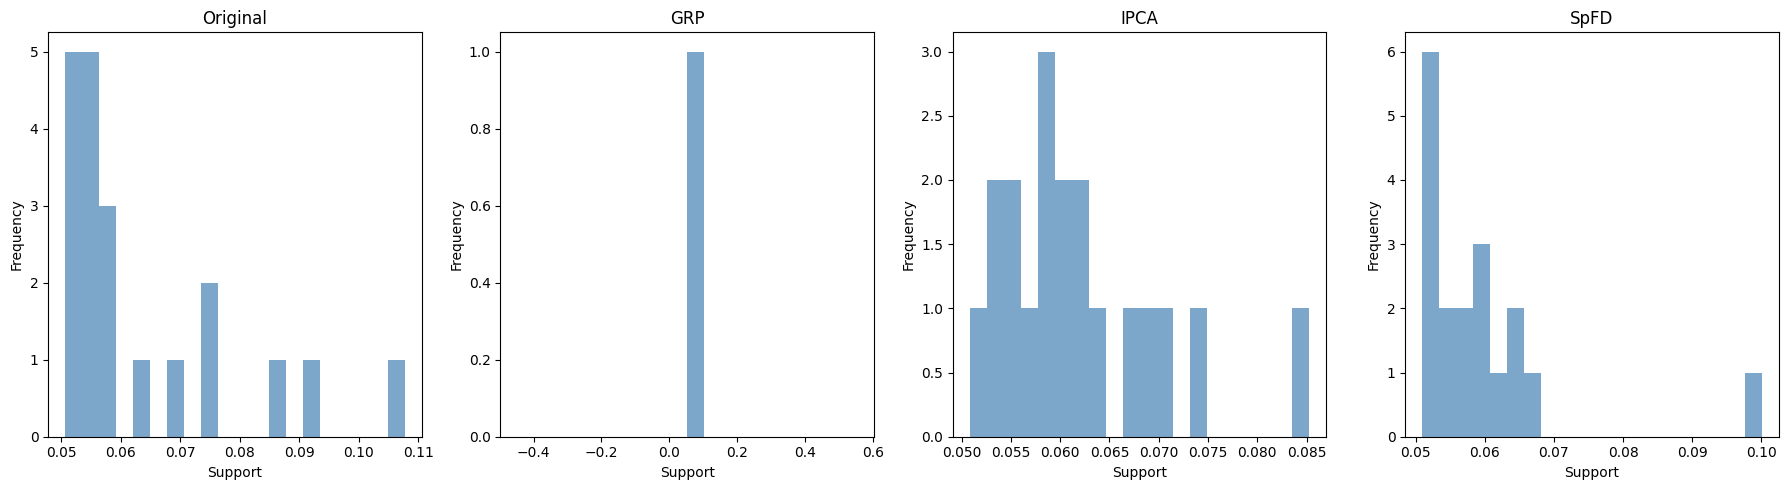


FP-Growth Summary Statistics:
  Original: Mean Support=0.0640, Median=0.0566, Max=0.1077, Min=0.0507
  GRP: Mean Support=0.0525, Median=0.0525, Max=0.0525, Min=0.0525
  IPCA: Mean Support=0.0618, Median=0.0598, Max=0.0853, Min=0.0508
  SpFD: Mean Support=0.0594, Median=0.0570, Max=0.1000, Min=0.0509


In [14]:
# ==========================================
# Frequent Pattern Mining (FP-Growth)
# ==========================================

# Define datasets
analysis_matrices = {
    'Original': transaction_matrix,
    'GRP': grp_bin,
    'IPCA': ipca_bin,
    'SpFD': spfd_bin
}

# Configuration
SUPPORT_THRESHOLD = 0.05

# Results container
fpgrowth_results = {}

# Execute FP-Growth
for label, matrix_data in analysis_matrices.items():
    print(f"Running FP-Growth on {label}...")
    t_start = time.time()
    
    # Mining
    found_patterns = fpgrowth(matrix_data, min_support=SUPPORT_THRESHOLD, use_colnames=True)
    
    t_end = time.time()
    duration = t_end - t_start
    count = len(found_patterns)
    
    # Save
    fpgrowth_results[label] = {
        'time': duration,
        'n_patterns': count,
        'patterns': found_patterns
    }
    
    print(f"  Time: {duration:.2f}s, Patterns: {count}")


# ==========================================
# Performance Visualization
# ==========================================
labels = list(analysis_matrices.keys())
durations = [fpgrowth_results[k]['time'] for k in labels]
counts = [fpgrowth_results[k]['n_patterns'] for k in labels]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Time
axes[0].bar(labels, durations, color='skyblue')
axes[0].set_title('FP-Growth Execution Time Comparison')
axes[0].set_ylabel('Time (seconds)')
axes[0].grid(True, alpha=0.3)

# Pattern Count
axes[1].bar(labels, counts, color='salmon')
axes[1].set_title('FP-Growth: Number of Patterns Comparison')
axes[1].set_ylabel('Number of Patterns')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# ==========================================
# Support Distribution
# ==========================================
fig, axes = plt.subplots(1, len(labels), figsize=(18, 5))

for idx, label in enumerate(labels):
    pats = fpgrowth_results[label]['patterns']
    
    if not pats.empty:
        axes[idx].hist(pats['support'], bins=20, alpha=0.7, color='steelblue')
        axes[idx].set_title(f'{label}')
        axes[idx].set_xlabel('Support')
        axes[idx].set_ylabel('Frequency')
    else:
        axes[idx].text(0.5, 0.5, 'No patterns', ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'{label}')

plt.tight_layout()
plt.show()


# ==========================================
# Statistical Summary
# ==========================================
print("\nFP-Growth Summary Statistics:")
for label in labels:
    pats = fpgrowth_results[label]['patterns']
    
    if not pats.empty:
        avg_sup = pats['support'].mean()
        med_sup = pats['support'].median()
        max_sup = pats['support'].max()
        min_sup = pats['support'].min()
        print(f"  {label}: Mean Support={avg_sup:.4f}, "
              f"Median={med_sup:.4f}, Max={max_sup:.4f}, Min={min_sup:.4f}")
    else:
        print(f"  {label}: No patterns found")

## 6. Anomaly Detection
Inject synthetic anomalies into the data and evaluate the ability of each method to detect them based on reconstruction error.

Base anomalous pattern: [0.32311543 0.50755523 0.38693703 ... 0.32616936 0.53943965 0.37554824]
Injecting anomalies into batches: [6 5 8]
  - Injected 200 anomalous rows into batch 6.
  - Injected 200 anomalous rows into batch 5.
  - Injected 200 anomalous rows into batch 8.


Processing SpFD: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


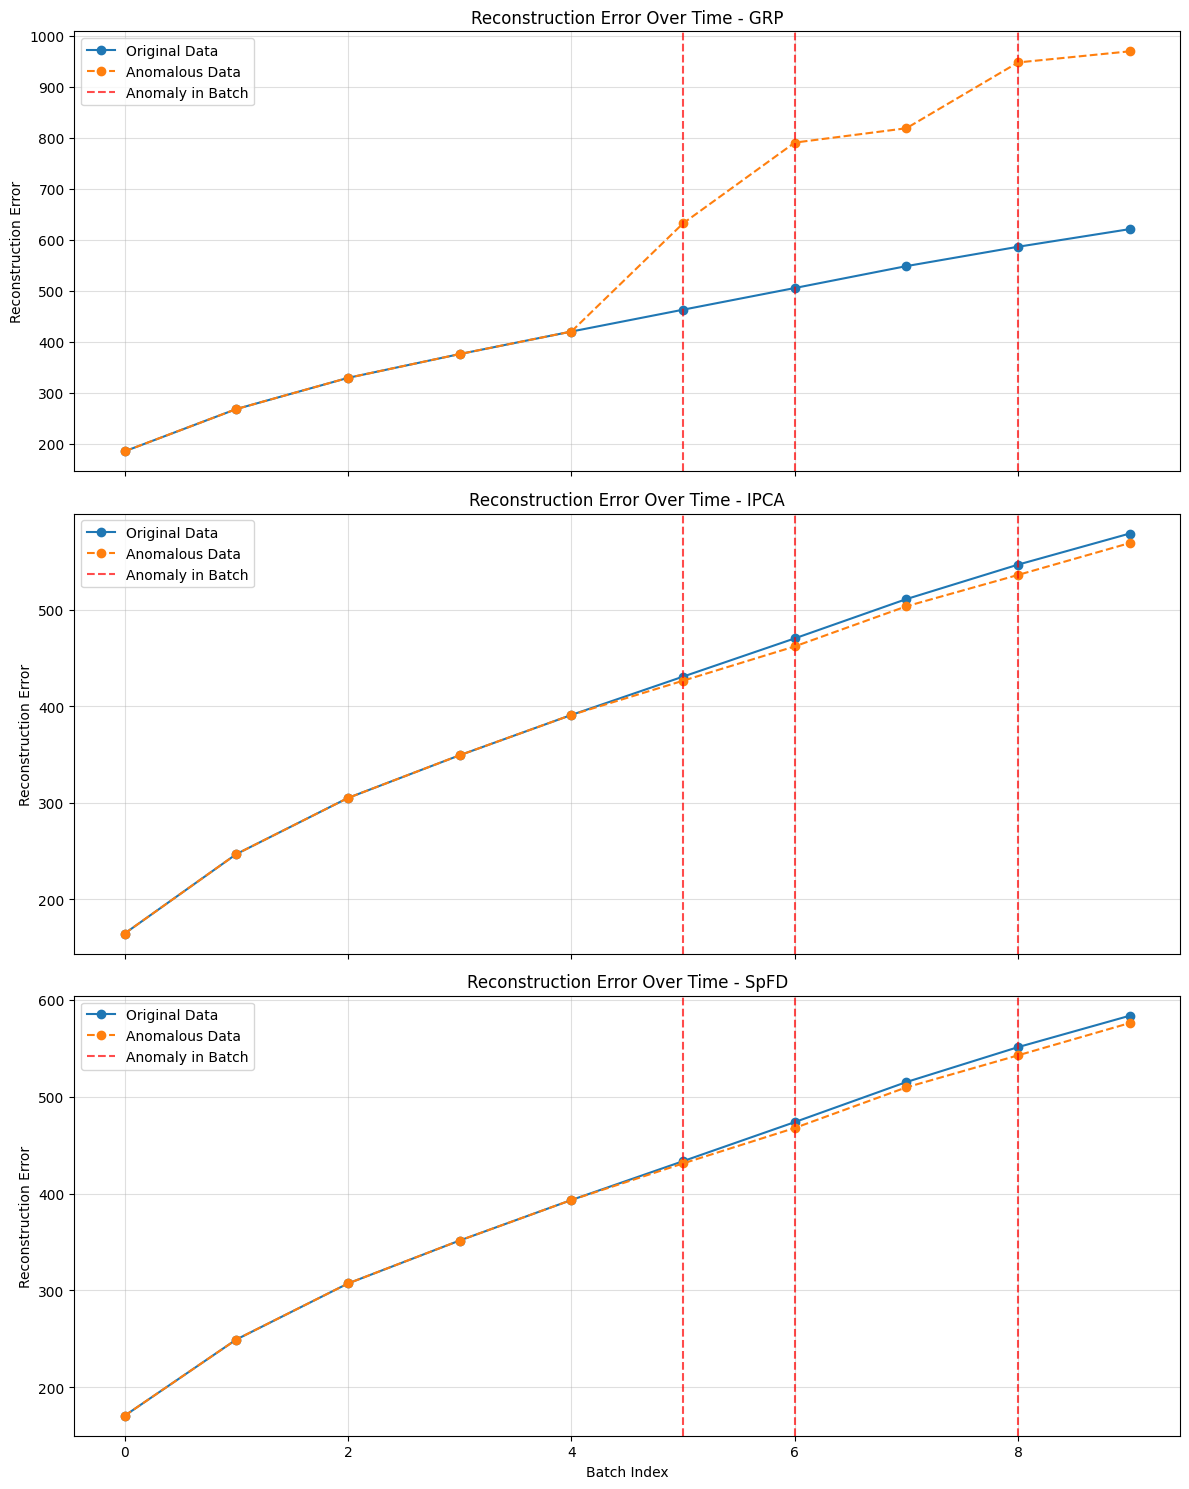

In [15]:
# ==========================================
# Anomaly Injection
# ==========================================

# Clone data
anomalous_batches = copy.deepcopy(data_chunks)
anomaly_log = {}

np.random.seed(2020)

feat_count = data_chunks[0].shape[1]

# Generate noise pattern
avg_val, std_val = 0.5, 0.1
noise_pattern = np.random.normal(loc=avg_val, scale=std_val, size=feat_count)
noise_pattern = np.clip(noise_pattern, 0, 1)

print("Base anomalous pattern:", noise_pattern)

# Add spikes
spike_indices = np.random.choice(feat_count, 5, replace=False)
noise_pattern[spike_indices] = 1

# Select batches
num_anom_batches = 3
target_batch_indices = np.random.choice(range(2, num_chunks), num_anom_batches, replace=False)
print(f"Injecting anomalies into batches: {target_batch_indices}")

# Inject
for b_idx in target_batch_indices:
    b_df = anomalous_batches[b_idx]
    row_count = b_df.shape[0]
    
    num_bad_rows = 200
    bad_row_indices = np.random.choice(row_count, num_bad_rows, replace=False)
    
    anomaly_log[b_idx] = bad_row_indices
    
    b_df.iloc[bad_row_indices] = noise_pattern
    print(f"  - Injected {num_bad_rows} anomalous rows into batch {b_idx}.")


# ==========================================
# Error Calculation Utility
# ==========================================
def compute_rec_errors(batch_list, model_func, method_label):
    """
    Calculates reconstruction errors for a sequence of batches.
    """
    errors = []
    accum_data = None
    
    # No special handling for IPCA needed anymore as we use numpy
    iter_data = batch_list

    for current_batch in tqdm(iter_data, desc=f"Processing {method_label}"):
        # Accumulate
        curr_np = current_batch.values if hasattr(current_batch, 'values') else current_batch
        if accum_data is None:
            accum_data = curr_np
        else:
            accum_data = np.vstack((accum_data, curr_np))
        
        # Reconstruct
        recon = model_func(accum_data)
        
        # Error
        err = np.linalg.norm(accum_data - recon, 'fro')
        errors.append(err)
        
    return errors


# ==========================================
# Model Wrappers
# ==========================================
def run_grp(data):
    _, recon = apply_grp(data, k=TARGET_DIM)
    return recon

anom_pca = IncrementalPCA(n_components=NUM_COMPONENTS)
def run_ipca(data):
    # Manual batching for IPCA
    n_samples = data.shape[0]
    rec_list = []
    
    for start_idx in range(0, n_samples, MINI_BATCH_SIZE):
        end_idx = min(start_idx + MINI_BATCH_SIZE, n_samples)
        batch = data[start_idx:end_idx]
        
        anom_pca.partial_fit(batch)
        p = anom_pca.transform(batch)
        rec_list.append(anom_pca.inverse_transform(p))
        
    return np.vstack(rec_list)

anom_spfd = SparseFrequentDirections(sketch_dim=SKETCH_DIM, rank=TARGET_DIM, blocks=BLOCK_COUNT)
def run_spfd(data):
    _, recon = anom_spfd.fit_transform(data)
    return recon


# ==========================================
# Anomaly Detection
# ==========================================
grp_anom_errors = compute_rec_errors(anomalous_batches, run_grp, "GRP")
ipca_anom_errors = compute_rec_errors(anomalous_batches, run_ipca, "IPCA")
spfd_anom_errors = compute_rec_errors(anomalous_batches, run_spfd, "SpFD")


# ==========================================
# Visualization
# ==========================================
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Compare
algo_map = {
    'GRP': (grp_rec_errors, grp_anom_errors),
    'IPCA': (ipca_rec_errors, ipca_anom_errors),
    'SpFD': (spfd_rec_errors, spfd_anom_errors)
}

for ax, (label, (orig_err, anom_err)) in zip(axes, algo_map.items()):
    ax.plot(range(num_chunks), orig_err, 'o-', label='Original Data')
    ax.plot(range(num_chunks), anom_err, 'o--', label='Anomalous Data')
    
    # Markers
    for b_idx in target_batch_indices:
        ax.axvline(x=b_idx, color='r', linestyle='--', alpha=0.7,
                   label='Anomaly in Batch' if b_idx == target_batch_indices[0] else "")
    
    ax.set_title(f'Reconstruction Error Over Time - {label}')
    ax.set_ylabel('Reconstruction Error')
    ax.legend()
    ax.grid(True, alpha=0.4)

axes[-1].set_xlabel('Batch Index')
plt.tight_layout()
plt.show()